In [1]:
import pandas as pd 

import json
import pandas as pd 
from typing import List, Dict
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

In [2]:
def hierarchical_exact_match(test_data: List[Dict]) -> float:
    """
    Calculates hierarchical exact match accuracy (HEM).
    Only counts a prediction as correct if both levels are correct.
    
    Reference: Kosmopoulos et al. (2015) https://arxiv.org/pdf/1306.6802
    """
    correct = sum(
        1 for item in test_data
        if item['true_global_topic'] == item['pred_global_topic']
        and item['true_subtopic'] == item['pred_subtopic']
    )
    return correct / len(test_data)

def hierarchical_precision_recall(test_data: List[Dict]) -> Dict:
    """
    Calculates hierarchical precision and recall (hP and hR).
    Takes into account the hierarchical structure when computing metrics.
    
    Reference: Kiritchenko et al. (2005)
    https://www.researchgate.net/profile/Svetlana-Kiritchenko/publication/44054157_Hierarchical_Text_Categorization_as_a_Tool_of_Associating_Genes_with_Gene_Ontology_Codes/links/09e4150b3962e7f77e000000/Hierarchical-Text-Categorization-as-a-Tool-of-Associating-Genes-with-Gene-Ontology-Codes.pdf
    https://www.mdpi.com/2079-9292/13/7/1199#sec3dot1dot4-electronics-13-01199 (good)
    """
    total_precision = 0
    total_recall = 0
    
    for item in test_data:
        # Create sets of predicted and true paths
        true_path = {item['true_global_topic'], f"{item['true_global_topic']}/{item['true_subtopic']}"}
        pred_path = {item['pred_global_topic'], f"{item['pred_global_topic']}/{item['pred_subtopic']}"}
        # print()
        # Calculate the intersection of predicted and true paths
        common = len(true_path.intersection(pred_path))
        
        # Calculate precision and recall for this instance
        precision = common / len(pred_path) if pred_path else 0
        recall = common / len(true_path) if true_path else 0
        
        total_precision += precision
        total_recall += recall
    
    avg_precision = total_precision / len(test_data)
    avg_recall = total_recall / len(test_data)
    
    # Calculate hierarchical F1
    h_f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
    
    return {
        'hierarchical_precision': avg_precision,
        'hierarchical_recall': avg_recall,
        'hierarchical_f1': h_f1
    }
def level_based_accuracy(test_data: List[Dict]) -> Dict:
    """
    Calculates accuracy at each level and the weighted combination.
    
    Reference: Sun & Lim (2001)
    """
    # Level 1 (Global Topic) accuracy https://ink.library.smu.edu.sg/cgi/viewcontent.cgi?article=1975&context=sis_research
    l1_correct = sum(
        1 for item in test_data
        if item['true_global_topic'] == item['pred_global_topic']
    )
    l1_accuracy = l1_correct / len(test_data)
    
    # Level 2 (Subtopic) accuracy, only considering cases where level 1 was correct
    l2_eligible = sum(
        1 for item in test_data
        if item['true_global_topic'] == item['pred_global_topic']
    )
    l2_correct = sum(
        1 for item in test_data
        if item['true_global_topic'] == item['pred_global_topic']
        and item['true_subtopic'] == item['pred_subtopic']
    )
    l2_accuracy = l2_correct / l2_eligible if l2_eligible > 0 else 0
    
    # Weighted combination (adjust weights based on importance)
    w1, w2 = 0.6, 0.4  # Example weights
    weighted_accuracy = (w1 * l1_accuracy) + (w2 * l2_accuracy)
    
    return {
        'level1_accuracy': l1_accuracy,
        'level2_accuracy': l2_accuracy,
        'weighted_accuracy': weighted_accuracy
    }

def evaluate_hierarchical_classification(test_data: List[Dict]) -> Dict:
    """
    Comprehensive evaluation of hierarchical classification performance.
    """
    metrics = {}
    
    # Basic hierarchical exact match
    metrics['exact_match'] = hierarchical_exact_match(test_data)
    
    # Hierarchical precision and recall
    h_metrics = hierarchical_precision_recall(test_data)
    metrics.update(h_metrics)
    
    # Level-based accuracy
    l_metrics = level_based_accuracy(test_data)
    metrics.update(l_metrics)
    
    return metrics

In [6]:
!pwd

/Users/sumonkantidey/Desktop/CareLab/hierarchical-srh-intent/confidence_intervals


In [9]:
# load model prediction 
llama3_70b = "../output/llama3.3-70b.json"
llama3_8b = "../output/llama-3.1-8b.json"
gpt_4o = "../output/gpt-4o.json"
gpt_5 = "../output/gpt-5.json"

gemma3_27b = "../output/gemma-3-27b.json"
gemma2_9b = "../output/gemma-2-9b.json"
qwen_7b = "../output/qwen-2.5-7b.json"
mixtral_7b = "../output/mixtral-8-7b.json"
aya_8b = "../output/aya-expanse-8b.json"
llama3_Gaja_8b = "../output/LLama3-Gaja-Hindi-8B-v0.1.json"
AryaBhatta = "../output/AryaBhatta.json"
claude_3_sonnet="../output/claude-3.5-sonnet.json"
airavata = "../output/Airavata.json"
Krutrim2_12B_instruct = "../output/Krutrim.json"
sarvam_m = "../output/sarvam-m.json"

# reported_models = [GPT-5, GPT-4o, Claude-3.5-Sonnet, Llama-3.3-70B-Instruct, Gemma-3-27B-IT, LLama3-Gaja-Hindi-8B, Sarvam-M]

# choose the model from reported_models and take the model_data_path accordingly 
model_name = "LLaMA-3-Gaja-Hindi-8B"
model_data_path = llama3_Gaja_8b

with open(model_data_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

pred = []
for d in data: 
    pred.append({
        "Index": d['Index'],
        "pred_topic": d['topic'],
        "pred_subtopic": d['subtopic']
    })

model_pred = pd.DataFrame(pred)
data[0], model_pred['pred_topic'][4], len(model_pred)

({'Index': 0,
  'query': 'kya is it normal to have irregular periods',
  'topic': 'Menstrual Health',
  'subtopic': 'Menstrual Cycle Information',
  'confidence': 0.9,
  'reason': 'The query is about understanding the normalcy of irregular periods, which falls under menstrual cycle information.',
  'raw_output': '```json\n{\n  "Topic": "Menstrual Health",\n  "Subtopic": "Menstrual Cycle Information",\n  "Confidence": 0.9,\n  "Reason": "The query is about understanding the normalcy of irregular periods, which falls under menstrual cycle information."\n}',
  'model': 'Cognitive-Lab/LLama3-Gaja-Hindi-8B-v0.1'},
 'PCOS or PCOD',
 4161)

In [10]:
model_pred.isnull().sum()

Index            0
pred_topic       0
pred_subtopic    0
dtype: int64

In [11]:
model_pred['pred_topic'].value_counts() 

pred_topic
Menstrual Health                     1377
Contraception and Family Planning    1291
Pregnancy and PNC                     618
Sexual and Vaginal Health             483
PCOS or PCOD                          121
Other                                  83
Diet and Nutrition                     73
HIV                                    42
Mental Health and Wellness             37
Exercise and Fitness                   12
Marriage & Relationships               12
Breastfeeding                           3
Vaginal and Uterine Health              2
Vaginal and Sexual Health               2
Vaginal Health and Discharge            2
Period Pain Management                  1
Sterilization                           1
Relationship and Marriage               1
Name: count, dtype: int64

In [174]:
def topic_post_processing(topic):
    if topic in ['PCOS or PCOD', 'PCOD or PCOD', 'PCOD', 'PCOS', 'PCOS and PCOD']: 
        return 'PCOS/PCOD'
    elif topic in ['Genetics or Pregnancy and PNC is not present but closest is Pregnancy and PNC']: 
        return 'Pregnancy and PNC'
    elif topic in ['Contraceception and Family Planning', 'Family Planning']: 
        return 'Contraception and Family Planning'
    elif topic in ['Vaginal and Sexual Health', 'Sexual Health', 'Vaginal and Uterine Health', 'Vaginal Health and Discharge']: 
        return 'Sexual and Vaginal Health'
    else:
        return topic

model_pred['pred_topic'] = model_pred['pred_topic'].apply(lambda x: topic_post_processing(x))

In [175]:
model_pred['pred_topic'].values

array(['Menstrual Health', 'Menstrual Health', 'Menstrual Health', ...,
       'Menstrual Health', 'PCOS/PCOD',
       'Contraception and Family Planning'], shape=(4161,), dtype=object)

In [176]:
model_pred.head(2)

,Index,pred_topic,pred_subtopic
0,0,Menstrual Health,Menstrual Cycle Information
1,1,Menstrual Health,Menstrual Flow


In [177]:
data = pd.read_excel("./data/hinglish/final_jmir_data/cleaned_data_for_jmir.xlsx")
data.head(2)

,Message ID,Index,User Content,Topic,Sub Topic
0,19676,0,kya is it normal to have irregular periods,Menstrual Health,Menstrual Cycle Information
1,19844,1,Mere private part ke aas paas jalne jaisa mehsoos ho raha hai periods ke dauraan.,Menstrual Health,Period Pain Management


In [178]:
data.isnull().sum()

Message ID      504
Index             0
User Content      0
Topic             0
Sub Topic         0
dtype: int64

In [179]:
data['Topic'].value_counts()

Topic
Contraception and Family Planning    1417
Menstrual Health                     1104
Other                                 596
Pregnancy and PNC                     547
Sexual and Vaginal Health             322
PCOS/PCOD                             101
HIV                                    52
Mental Health and Wellness             22
Name: count, dtype: int64

In [180]:
merged_df = pd.merge(data, model_pred, on='Index', how='inner')
merged_df.head(2)

,Message ID,Index,User Content,Topic,Sub Topic,pred_topic,pred_subtopic
0,19676,0,kya is it normal to have irregular periods,Menstrual Health,Menstrual Cycle Information,Menstrual Health,Menstrual Cycle Information
1,19844,1,Mere private part ke aas paas jalne jaisa mehsoos ho raha hai periods ke dauraan.,Menstrual Health,Period Pain Management,Menstrual Health,Menstrual Flow


In [181]:
merged_df['pred_topic'].value_counts()

pred_topic
Menstrual Health                     1377
Contraception and Family Planning    1291
Pregnancy and PNC                     618
Sexual and Vaginal Health             489
PCOS/PCOD                             121
Other                                  83
Diet and Nutrition                     73
HIV                                    42
Mental Health and Wellness             37
Exercise and Fitness                   12
Marriage & Relationships               12
Breastfeeding                           3
Sterilization                           1
Period Pain Management                  1
Relationship and Marriage               1
Name: count, dtype: int64

In [182]:
model_test_data = []
for index, row in merged_df.iterrows(): 
    model_test_data.append({
        'true_global_topic': row['Topic'],
        'true_subtopic': row['Sub Topic'], 
        'pred_global_topic': row['pred_topic'], 
        'pred_subtopic': row['pred_subtopic']
    })

In [183]:
metrics = evaluate_hierarchical_classification(model_test_data)
print(model_data_path)
metrics

output/LLama3-Gaja-Hindi-8B-v0.1.json


{'exact_match': 0.4518144676760394,
 'hierarchical_precision': 0.5962509012256669,
 'hierarchical_recall': 0.5962509012256669,
 'hierarchical_f1': 0.5962509012256669,
 'level1_accuracy': 0.7406873347752944,
 'level2_accuracy': 0.6099935107073329,
 'weighted_accuracy': 0.6884098051481098}

In [184]:
valid_topics = ['Contraception and Family Planning', 'Sexual and Vaginal Health', 'HIV', 'Pregnancy and PNC', 
                'PCOS/PCOD', 'Menstrual Health', 'Mental Health and Wellness', 'Other']
valid_topics

['Contraception and Family Planning',
 'Sexual and Vaginal Health',
 'HIV',
 'Pregnancy and PNC',
 'PCOS/PCOD',
 'Menstrual Health',
 'Mental Health and Wellness',
 'Other']

In [185]:
model_name

'LLaMA-3-Gaja-Hindi-8B'

In [186]:
# # All Topic Acc and F1 score  
# import pandas as pd
# from sklearn.metrics import accuracy_score, classification_report

# # Get unique topics
# topics = merged_df['Topic'].unique()

# report_dict = classification_report(merged_df['Topic'], merged_df['pred_topic'], output_dict=True)

# for class_label in topics:
#     metrics = report_dict.get(class_label, None)
#     if metrics:
#         print(f"Class: {class_label}")
#         for metric, value in metrics.items():
#             print(f"  {metric.capitalize()}: {value:.2f}")
#         print("-" * 30)


In [187]:
# Extract topic-level true and predicted labels
# Extract topic-level labels
print(model_data_path)
true_topics = [item['true_global_topic'] for item in model_test_data]
pred_topics = [
    item['pred_global_topic'] if item['pred_global_topic'] in valid_topics else None
    for item in model_test_data
]

# Keep only pairs where prediction is in valid topics
filtered_true = []
filtered_pred = []
for t, p in zip(true_topics, pred_topics):
    if p is not None:     # exclude NotValid
        filtered_true.append(t)
        filtered_pred.append(p)

from sklearn.metrics import accuracy_score, classification_report

topic_acc = accuracy_score(filtered_true, filtered_pred)
print(f"Topic-Level Accuracy (excluding NotValid): {topic_acc:.3f}")


topic_report = classification_report(
    filtered_true,
    filtered_pred,
    labels=valid_topics,         # only valid classes
    target_names=valid_topics,
    digits=3
    # output_dict=True    
)

print("Topic-Level Classification Report (Excluding NotValid):\n")
print(topic_report)


output/LLama3-Gaja-Hindi-8B-v0.1.json
Topic-Level Accuracy (excluding NotValid): 0.759
Topic-Level Classification Report (Excluding NotValid):

                                   precision    recall  f1-score   support

Contraception and Family Planning      0.883     0.809     0.844      1410
        Sexual and Vaginal Health      0.442     0.673     0.533       321
                              HIV      1.000     0.808     0.894        52
                Pregnancy and PNC      0.720     0.824     0.769       540
                        PCOS/PCOD      0.752     0.901     0.820       101
                 Menstrual Health      0.771     0.963     0.856      1102
       Mental Health and Wellness      0.432     0.727     0.542        22
                            Other      0.855     0.139     0.239       510

                         accuracy                          0.759      4058
                        macro avg      0.732     0.730     0.687      4058
                     weighted

In [188]:
# Get report as dictionary instead of string
print(model_data_path)
print("--"*20)
topic_report = classification_report(
    filtered_true,
    filtered_pred,
    labels=valid_topics,
    target_names=valid_topics,
    digits=2,
    output_dict=True
)

# Extract only F1-scores
f1_scores = {label: round(metrics["f1-score"], 2) for label, metrics in topic_report.items() if label in valid_topics}


topics = [
    "Contraception and Family Planning", "Menstrual Health", "Pregnancy and PNC", "Sexual and Vaginal Health",
    "PCOS/PCOD", "HIV", "Mental Health and Wellness", "Other"
]
for topic in topics: 
    print(f"{topic} = {f1_scores[topic]}")
    

output/LLama3-Gaja-Hindi-8B-v0.1.json
----------------------------------------
Contraception and Family Planning = 0.84
Menstrual Health = 0.86
Pregnancy and PNC = 0.77
Sexual and Vaginal Health = 0.53
PCOS/PCOD = 0.82
HIV = 0.89
Mental Health and Wellness = 0.54
Other = 0.24


In [189]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

def bootstrap_f1_ci_by_class(df, y_true_col, y_pred_col, classes=None,
                             B=5000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    y_true = df[y_true_col].astype(str).to_numpy()
    y_pred = df[y_pred_col].astype(str).to_numpy()

    if classes is None:
        classes = np.unique(y_true)

    rows = []
    n = len(df)

    # point estimates on full data
    for c in classes:
        f1 = f1_score(y_true == c, y_pred == c, zero_division=0)
        rows.append({"Class": c, "F1": f1})

    point_df = pd.DataFrame(rows).set_index("Class")

    # bootstrap distributions
    boot = {c: [] for c in classes}
    for _ in range(B):
        idx = rng.integers(0, n, size=n)  # resample rows with replacement
        yt = y_true[idx]
        yp = y_pred[idx]
        for c in classes:
            boot[c].append(f1_score(yt == c, yp == c, zero_division=0))

    # CIs
    out_rows = []
    for c in classes:
        dist = np.asarray(boot[c])
        lo = np.quantile(dist, alpha/2)
        hi = np.quantile(dist, 1 - alpha/2)
        out_rows.append({
            "Class": c,
            "F1": float(point_df.loc[c, "F1"]),
            "CI_low": float(lo),
            "CI_high": float(hi),
            "Support": int(np.sum(y_true == c))
        })

    return pd.DataFrame(out_rows).sort_values("Support")
    
ci_df = bootstrap_f1_ci_by_class(
    merged_df,
    y_true_col="Topic",
    y_pred_col="pred_topic",
    B=10000,      # 5000–10000 is typical
    seed=0
)

# nicer formatting
ci_df["F1"] = ci_df["F1"].round(2)
ci_df["CI_low"] = ci_df["CI_low"].round(2)
ci_df["CI_high"] = ci_df["CI_high"].round(2)

print(ci_df)


                               Class    F1  CI_low  CI_high  Support
3         Mental Health and Wellness  0.54    0.37     0.69       22
1                                HIV  0.89    0.82     0.95       52
5                          PCOS/PCOD  0.82    0.76     0.87      101
7          Sexual and Vaginal Health  0.53    0.49     0.57      322
6                  Pregnancy and PNC  0.76    0.74     0.79      547
4                              Other  0.21    0.17     0.25      596
2                   Menstrual Health  0.86    0.84     0.87     1104
0  Contraception and Family Planning  0.84    0.83     0.86     1417


In [109]:
gpt_5_df = ci_df
gpt_5_df

,Class,F1,CI_low,CI_high,Support
3,Mental Health and Wellness,0.65,0.49,0.77,22
1,HIV,0.98,0.95,1.00,52
5,PCOS/PCOD,0.91,0.87,0.95,101
7,Sexual and Vaginal Health,0.80,0.77,0.83,322
6,Pregnancy and PNC,0.85,0.83,0.88,547
4,Other,0.79,0.76,0.81,596
2,Menstrual Health,0.92,0.91,0.93,1104
0,Contraception and Family Planning,0.93,0.92,0.94,1417


In [ ]:
claude_3_sonnet_df = ci_df
claude_3_sonnet_df

,Class,F1,CI_low,CI_high,Support
3,Mental Health and Wellness,0.47,0.33,0.60,22
1,HIV,0.95,0.90,0.98,52
5,PCOS/PCOD,0.85,0.79,0.89,101
7,Sexual and Vaginal Health,0.76,0.72,0.79,322
6,Pregnancy and PNC,0.83,0.80,0.85,547
4,Other,0.66,0.62,0.69,596
2,Menstrual Health,0.90,0.89,0.91,1104
0,Contraception and Family Planning,0.93,0.92,0.94,1417


In [150]:
llama3_70b_df = ci_df
llama3_70b_df

,Class,F1,CI_low,CI_high,Support
3,Mental Health and Wellness,0.46,0.33,0.58,22
1,HIV,0.94,0.89,0.98,52
5,PCOS/PCOD,0.81,0.75,0.86,101
7,Sexual and Vaginal Health,0.75,0.71,0.79,322
6,Pregnancy and PNC,0.84,0.82,0.87,547
4,Other,0.59,0.55,0.63,596
2,Menstrual Health,0.90,0.89,0.91,1104
0,Contraception and Family Planning,0.93,0.92,0.94,1417


In [170]:
gemma3_27b_df = ci_df
gemma3_27b_df

,Class,F1,CI_low,CI_high,Support
3,Mental Health and Wellness,0.58,0.43,0.71,22
1,HIV,0.95,0.90,0.99,52
5,PCOS/PCOD,0.79,0.72,0.84,101
7,Sexual and Vaginal Health,0.74,0.70,0.78,322
6,Pregnancy and PNC,0.83,0.80,0.85,547
4,Other,0.61,0.57,0.64,596
2,Menstrual Health,0.92,0.91,0.94,1104
0,Contraception and Family Planning,0.92,0.91,0.93,1417


In [88]:
sarvam_df = ci_df
sarvam_df

,Class,F1,CI_low,CI_high,Support
3,Mental Health and Wellness,0.62,0.47,0.75,22
1,HIV,0.95,0.90,0.99,52
5,PCOS/PCOD,0.80,0.74,0.85,101
7,Sexual and Vaginal Health,0.78,0.74,0.81,322
6,Pregnancy and PNC,0.84,0.81,0.86,547
4,Other,0.70,0.67,0.74,596
2,Menstrual Health,0.92,0.90,0.93,1104
0,Contraception and Family Planning,0.92,0.91,0.93,1417


In [190]:
llama3_Gaja_8b_df = ci_df
llama3_Gaja_8b_df

,Class,F1,CI_low,CI_high,Support
3,Mental Health and Wellness,0.54,0.37,0.69,22
1,HIV,0.89,0.82,0.95,52
5,PCOS/PCOD,0.82,0.76,0.87,101
7,Sexual and Vaginal Health,0.53,0.49,0.57,322
6,Pregnancy and PNC,0.76,0.74,0.79,547
4,Other,0.21,0.17,0.25,596
2,Menstrual Health,0.86,0.84,0.87,1104
0,Contraception and Family Planning,0.84,0.83,0.86,1417


In [12]:
scores_dict = {
    
    "GPT-5": {
    "Contraception and Family Planning": {"f1": 0.93, "ci_low": 0.92, "ci_high": 0.94},
    "Menstrual Health": {"f1": 0.92, "ci_low": 0.91, "ci_high": 0.93},
    "Pregnancy and PNC": {"f1": 0.85, "ci_low": 0.83, "ci_high": 0.88},
    "Sexual and Vaginal Health": {"f1": 0.80, "ci_low": 0.77, "ci_high": 0.83},
    "PCOS/PCOD": {"f1": 0.91, "ci_low": 0.87, "ci_high": 0.95},
    "HIV": {"f1": 0.98, "ci_low": 0.95, "ci_high": 1.00},
    "Mental Health and Wellness": {"f1": 0.65, "ci_low": 0.49, "ci_high": 0.77},
    "Other": {"f1": 0.79, "ci_low": 0.76, "ci_high": 0.81},
    },

    "Claude-3.5-Sonnet": {
    "Contraception and Family Planning": {"f1": 0.93, "ci_low": 0.92, "ci_high": 0.94},
    "Menstrual Health": {"f1": 0.90, "ci_low": 0.89, "ci_high": 0.91},
    "Pregnancy and PNC": {"f1": 0.83, "ci_low": 0.80, "ci_high": 0.85},
    "Sexual and Vaginal Health": {"f1": 0.76, "ci_low": 0.72, "ci_high": 0.79},
    "PCOS/PCOD": {"f1": 0.85, "ci_low": 0.79, "ci_high": 0.89},
    "HIV": {"f1": 0.95, "ci_low": 0.90, "ci_high": 0.98},
    "Mental Health and Wellness": {"f1": 0.47, "ci_low": 0.33, "ci_high": 0.60},
    "Other": {"f1": 0.66, "ci_low": 0.62, "ci_high": 0.69},
    },

    "Llama-3.3-70B-Instruct": {
    "Contraception and Family Planning": {"f1": 0.93, "ci_low": 0.92, "ci_high": 0.94},
    "Menstrual Health": {"f1": 0.90, "ci_low": 0.89, "ci_high": 0.91},
    "Pregnancy and PNC": {"f1": 0.84, "ci_low": 0.82, "ci_high": 0.87},
    "Sexual and Vaginal Health": {"f1": 0.75, "ci_low": 0.71, "ci_high": 0.79},
    "PCOS/PCOD": {"f1": 0.81, "ci_low": 0.75, "ci_high": 0.86},
    "HIV": {"f1": 0.94, "ci_low": 0.89, "ci_high": 0.98},
    "Mental Health and Wellness": {"f1": 0.46, "ci_low": 0.33, "ci_high": 0.58},
    "Other": {"f1": 0.59, "ci_low": 0.55, "ci_high": 0.63},
    },

    "Gemma-3-27B-IT": {
    "Contraception and Family Planning": {"f1": 0.92, "ci_low": 0.91, "ci_high": 0.93},
    "Menstrual Health": {"f1": 0.92, "ci_low": 0.91, "ci_high": 0.94},
    "Pregnancy and PNC": {"f1": 0.83, "ci_low": 0.80, "ci_high": 0.85},
    "Sexual and Vaginal Health": {"f1": 0.74, "ci_low": 0.70, "ci_high": 0.78},
    "PCOS/PCOD": {"f1": 0.79, "ci_low": 0.72, "ci_high": 0.84},
    "HIV": {"f1": 0.95, "ci_low": 0.90, "ci_high": 0.99},
    "Mental Health and Wellness": {"f1": 0.58, "ci_low": 0.43, "ci_high": 0.71},
    "Other": {"f1": 0.61, "ci_low": 0.57, "ci_high": 0.64},
    }, 
    
    "Sarvam-M": {
    "Contraception and Family Planning": {"f1": 0.92, "ci_low": 0.91, "ci_high": 0.93},
    "Menstrual Health": {"f1": 0.92, "ci_low": 0.90, "ci_high": 0.93},
    "Pregnancy and PNC": {"f1": 0.84, "ci_low": 0.81, "ci_high": 0.86},
    "Sexual and Vaginal Health": {"f1": 0.78, "ci_low": 0.74, "ci_high": 0.81},
    "PCOS/PCOD": {"f1": 0.80, "ci_low": 0.74, "ci_high": 0.85},
    "HIV": {"f1": 0.95, "ci_low": 0.90, "ci_high": 0.99},
    "Mental Health and Wellness": {"f1": 0.62, "ci_low": 0.47, "ci_high": 0.75},
    "Other": {"f1": 0.70, "ci_low": 0.67, "ci_high": 0.74},
    }, 
        
    "Llama-3-Gaja-Hindi-8B": {
    "Contraception and Family Planning": {"f1": 0.84, "ci_low": 0.83, "ci_high": 0.86},
    "Menstrual Health": {"f1": 0.86, "ci_low": 0.84, "ci_high": 0.87},
    "Pregnancy and PNC": {"f1": 0.76, "ci_low": 0.74, "ci_high": 0.79},
    "Sexual and Vaginal Health": {"f1": 0.53, "ci_low": 0.49, "ci_high": 0.57},
    "PCOS/PCOD": {"f1": 0.82, "ci_low": 0.76, "ci_high": 0.87},
    "HIV": {"f1": 0.89, "ci_low": 0.82, "ci_high": 0.95},
    "Mental Health and Wellness": {"f1": 0.54, "ci_low": 0.37, "ci_high": 0.69},
    "Other": {"f1": 0.21, "ci_low": 0.17, "ci_high": 0.25},
    }
}

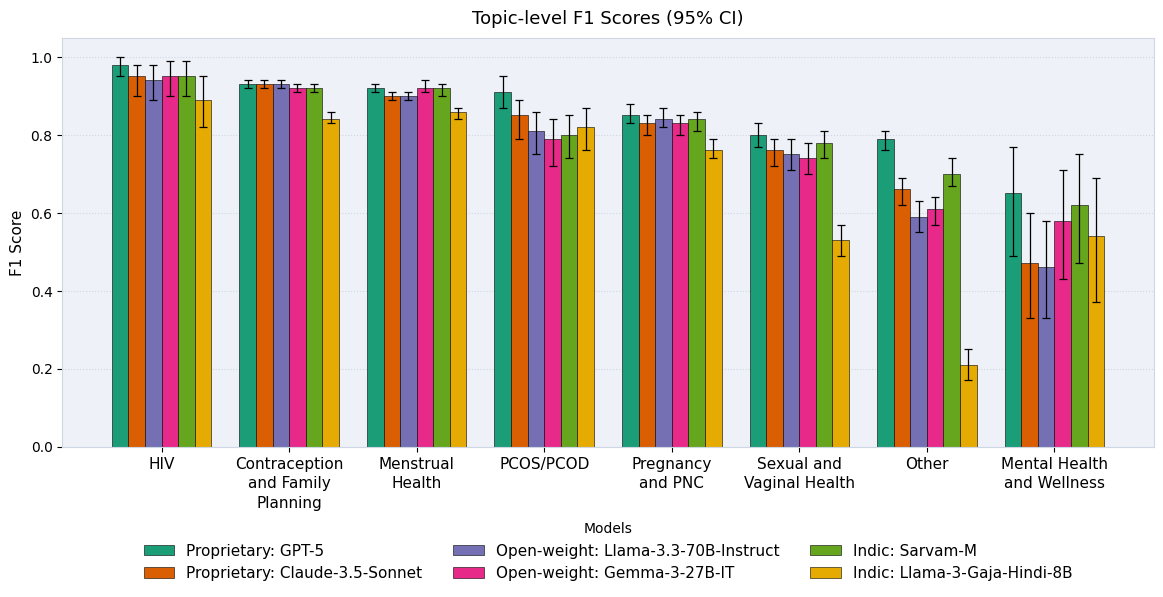

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# ---------------------------
# ---------------------------
# scores_dict = {"GPT-5": {"Topic": {"f1":..., "ci_low":..., "ci_high":...}, ...}, ...}

models = list(scores_dict.keys())

# Category for each model (same order as models)
categories = [
    "Proprietary", 
    "Proprietary",
    "Open-weight", 
    "Open-weight",
    "Indic", 
    "Indic"
]

# Topic order (optional). If None, it will infer from the first model.
topics = [
    "Contraception and Family Planning",
    "Menstrual Health",
    "Pregnancy and PNC",
    "Sexual and Vaginal Health",
    "PCOS/PCOD",
    "HIV",
    "Mental Health and Wellness",
    "Other",
]

# -------- Style (HealthBench-like) --------
plt.rcParams["font.family"]  = "DejaVu Sans"
plt.rcParams["font.size"]    = 10
plt.rcParams["font.stretch"] = "expanded"

FIG_BG, AX_BG, GRID_CLR = "white", "#eef1f7", "#cfd6e4"

def wrap_words(s, width=12, max_lines=3):
    parts = textwrap.wrap(
        s, width=width,
        break_long_words=False,
        break_on_hyphens=False
    )
    if len(parts) > max_lines:
        parts = parts[:max_lines-1] + [" ".join(parts[max_lines-1:])]
    return "\n".join(parts)

manual_wrap = {
    "Contraception and Family Planning": "Contraception\nand Family\nPlanning",
    "Sexual and Vaginal Health":         "Sexual and\nVaginal Health",
    "Mental Health and Wellness":        "Mental Health\nand Wellness"
}

# ---------------------------
# 1) Compute topic means to sort (desc)
# ---------------------------
topic_means = {}
for t in topics:
    vals = []
    for m in models:
        if t in scores_dict[m]:
            vals.append(scores_dict[m][t]["f1"])
    if len(vals) == len(models):  # only keep topics present for all models
        topic_means[t] = float(np.mean(vals))

sorted_topics = sorted(topic_means, key=topic_means.get, reverse=True)

wrapped_topics = [manual_wrap.get(t, wrap_words(t, width=12, max_lines=3))
                  for t in sorted_topics]

# ---------------------------
# 2) Plot
# ---------------------------
fig, ax = plt.subplots(figsize=(15, 6), facecolor=FIG_BG)
ax.set_facecolor(AX_BG)

x = np.arange(len(sorted_topics))
bar_width = 0.13
offsets = [i * bar_width for i in range(len(models))]

handles, labels = [], []
deep_palette = list(plt.cm.Dark2.colors)

for i, (model, cat) in enumerate(zip(models, categories)):
    xpos = x + offsets[i]

    f1_vals = np.array([scores_dict[model][t]["f1"] for t in sorted_topics], dtype=float)
    lo_vals = np.array([scores_dict[model][t]["ci_low"] for t in sorted_topics], dtype=float)
    hi_vals = np.array([scores_dict[model][t]["ci_high"] for t in sorted_topics], dtype=float)

    # Bars
    h = ax.bar(
        xpos, f1_vals,
        width=bar_width,
        label=f"{cat}: {model}",
        color=deep_palette[i % len(deep_palette)],
        edgecolor="black",
        linewidth=0.4,
        zorder=2
    )
    handles.append(h[0])
    labels.append(f"{cat}: {model}")

    # 95% CI error bars (asymmetric)
    yerr = np.vstack([f1_vals - lo_vals, hi_vals - f1_vals])
    ax.errorbar(
        xpos, f1_vals,
        yerr=yerr,
        fmt="none",
        ecolor="black",
        elinewidth=0.9,
        capsize=3,
        capthick=0.9,
        zorder=3
    )

# Axis formatting
ax.set_xticks(x + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels(wrapped_topics, rotation=0, ha="center", fontsize=11)

for lbl in ax.get_xticklabels():
    lbl.set_linespacing(1.38)
    try:
        lbl.set_fontstretch("expanded")
    except Exception:
        pass

ax.set_ylabel("F1 Score", fontsize=11)
ax.set_ylim(0.0, 1.05)
ax.yaxis.grid(True, linestyle=":", linewidth=0.8, color=GRID_CLR, zorder=1)
for spine in ax.spines.values():
    spine.set_color(GRID_CLR)

ax.set_title("Topic-level F1 Scores (95% CI)", fontsize=13, fontweight="normal", pad=10)

# # Give more horizontal space to the plot (no right margin reserved for legend)
plt.subplots_adjust(bottom=0.28, right=0.50)

# Legend at the bottom, centered
ax.legend(
    handles=handles, labels=labels,
    title="Models",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),   # move lower/higher by changing -0.18
    ncol=min(3, len(models)), 
    frameon=False,
    fancybox=False,
    fontsize=11
)

plt.tight_layout()
fig.savefig("../figures/revised_topic_level_F1_scores_with_CI.png", dpi=600, bbox_inches="tight", pad_inches=0.2)
fig.savefig("../figures/JMIR_Fig/revised_topic_level_F1_scores_with_CI.png", dpi=100, bbox_inches="tight", pad_inches=0.2)

plt.show()


In [ ]:
from PIL import Image

img = Image.open("../figures/JMIR_Fig/revised_topic_level_F1_scores_with_CI.png")
print(img.size) 

(1183, 617)
